In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install lightgbm --upgrade
!pip install git+https://github.com/zalandoresearch/flair.git
!pip install shap

     |████████████████████████████████| 1.2MB 2.8MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Cloning https://github.com/zalandoresearch/flair.git to /tmp/pip-req-build-djqxqd21
  Running command git clone -q https://github.com/zalandoresearch/flair.git /tmp/pip-req-build-djqxqd21
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 798kB 2.6MB/s 
     |████████████████████████████████| 983kB 14.0MB/s 
     |████████████████████████████████| 573kB 21.6MB/s 
     |████████████████████████████████| 256kB 25.8MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 3.7MB 31.1MB/s 
     |████████████████████████████████| 1.0MB 38.4MB/s 
  Created wheel for flair: filename=flair-0.4.5-cp36-none-any.whl size=134979 sha256=fa5554b9aea85f72174b2ad312ca

In [4]:
cd drive/My\ Drive/bt5153_proj/

/content/drive/My Drive/bt5153_proj


In [5]:
import numpy as np
import pandas as pd
import pickle
from itertools import chain

# plot
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

# text preprocessing
import re
import nltk
# uncomment if not not downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')
nltk.download('names')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from textblob import TextBlob

# feature
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

# ML model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import shap
# DL model
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, BertEmbeddings
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.initializers import RandomUniform
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, SpatialDropout1D, Dropout, LSTM, Bidirectional, MaxPooling1D, GlobalMaxPooling1D, Flatten, concatenate

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Using TensorFlow backend.


In [6]:
# read training data
df = pd.read_csv("data/rotten_tomatoes_reviews.csv", dtype={'review_content':str})
df.head()

,rotten_tomatoes_link,review_date,critic_publication,critic_icon,critic_top,critic_score,review_content
0,/m/0814255,2015-01-09,Cinemaphile.org,Rotten,NaN,NaN,The plot uses the presence of the Greek gods a...
1,/m/0814255,2012-07-31,7M Pictures,Fresh,NaN,NaN,It provides a great adventure movie for the fa...
2,/m/0814255,2011-11-05,"Star-Democrat (Easton, MD)",Rotten,NaN,NaN,The premise of Percy Jackson & the Olympians: ...
3,/m/0814255,2011-04-25,ComingSoon.net,Rotten,NaN,NaN,Percy Jackson is simply uninspired in every si...
4,/m/0814255,2011-04-04,Movies.com,Rotten,NaN,NaN,It kind of just builds up to a lot of Not Much.


In [0]:
df_movies = pd.read_csv("data/rotten_tomatoes_movies.csv")

In [0]:
df_movies['in_theaters_date'] = pd.to_datetime(df_movies.in_theaters_date)

In [8]:
df_movies.in_theaters_date.describe()

count                   15823
unique                   5586
top       2002-01-01 00:00:00
freq                       28
first     1914-06-01 00:00:00
last      2019-12-07 00:00:00
Name: in_theaters_date, dtype: object

In [9]:
df_movies.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3


In [11]:
df.shape

(930942, 7)

In [0]:
# drop no review content rows
df.dropna(subset=['review_content', 'critic_icon'], inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873206 entries, 0 to 930937
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  873206 non-null  object 
 1   review_date           873206 non-null  object 
 2   critic_publication    873206 non-null  object 
 3   critic_icon           873206 non-null  object 
 4   critic_top            232954 non-null  object 
 5   critic_score          6463 non-null    float64
 6   review_content        873206 non-null  object 
dtypes: float64(1), object(6)
memory usage: 53.3+ MB


## Text Preprocessing

In [0]:
_standard_chars= " 0123456789abcdefghijklmnopqrstuvwxyz.,-_()[]{}!?:;'\"/\\%$`&=*+^~|<>"
_punct = ".,-_()[]{}!?:;'\"/\\%$`&=*+^~|<>" 
_CONTRACTION_MAP= {"she'll": 'she will', "shouldn't've": 'should not have', "she'll've": 'she will have', "don't": 'do not', "should've": 'should have', "won't": 'will not', "who'll've": 'who will have', "he's": 'he is', "when's": 'when is', "we've": 'we have', "he'd": 'he would', "ma'am": 'madam', "y'all're": 'you all are', "he'd've": 'he would have', "how'd'y": 'how do you', "shan't've": 'shall not have', "haven't": 'have not', "who's": 'who is', "they'd": 'they would', "oughtn't": 'ought not', "I'd": 'I would', "you've": 'you have', "i'm": 'i am', "she'd've": 'she would have', "we'll": 'we will', "mayn't": 'may not', "they've": 'they have', "mustn't've": 'must not have', "could've": 'could have', "what've": 'what have', "mustn't": 'must not', "isn't": 'is not', "that'd've": 'that would have', "i'll": 'i will', "why's": 'why is', "you'd": 'you would', "couldn't've": 'could not have', "they'll've": 'they will have', "we'd": 'we would', "y'all'd": 'you all would', "he'll've": 'he he will have', "shan't": 'shall not', "y'all'd've": 'you all would have', "there'd": 'there would', "needn't": 'need not', "where'd": 'where did', "hadn't've": 'had not have', "wouldn't've": 'would not have', "there's": 'there is', "shouldn't": 'should not', "they'll": 'they will', "needn't've": 'need not have', "mightn't": 'might not', "you're": 'you are', "so've": 'so have', "what'll": 'what will', "mightn't've": 'might not have', "hadn't": 'had not', "aren't": 'are not', "where's": 'where is', "i'll've": 'i will have', "wouldn't": 'would not', "i'd": 'i would', "weren't": 'were not', "would've": 'would have', "i'm": 'i am', "it'll": 'it will', "we'd've": 'we would have', "can't": 'cannot', "y'all": 'you all', "couldn't": 'could not', "how'll": 'how will', "doesn't": 'does not', "when've": 'when have', "how's": 'how is', "i've": 'i have', "it's": 'it is', "y'all've": 'you all have', "how'd": 'how did', "we're": 'we are', "i'd've": 'i would have', "it'd": 'it would', "what're": 'what are', "i've": 'i have', "oughtn't've": 'ought not have', "what's": 'what is', "ain't": 'is not', "who'll": 'who will', "i'd've": 'i would have', "must've": 'must have', "i'll": 'i will', "they're": 'they are', "you'd've": 'you would have', "wasn't": 'was not', "it'll've": 'it will have', "hasn't": 'has not', "won't've": 'will not have', "so's": 'so as', "you'll've": 'you will have', "there'd've": 'there would have', "i'll've": 'i will have', "didn't": 'did not', "where've": 'where have', "they'd've": 'they would have', "why've": 'why have', "it'd've": 'it would have', "who've": 'who have', "sha'n't": 'shall not', "to've": 'to have', "o'clock": 'of the clock', "let's": 'let us', "what'll've": 'what will have', "'cause": 'because', "might've": 'might have', "he'll": 'he will', "that'd": 'that would', "we'll've": 'we will have', "she'd": 'she would', "can't've": 'cannot have', "you'll": 'you will', "will've": 'will have', "she's": 'she is', "that's": 'that is'}
_URL_PATTERN = """(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))?"""

In [0]:
# helper functions for text preprocessing
def tokenize(text):
    return nltk.word_tokenize(text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_urls(text):
    return re.sub(_URL_PATTERN, '', text)

def remove_stopwords(text, lang='english'):
    """
    :param text: text input
    :return: text with stopwords removed
    :rtype: str 
    """
    words = nltk.word_tokenize(text)
    lang_stopwords= [i for i in stopwords.words(lang) if i not in ['not', 'no']]
    stopwords_removed= [w for w in words if w not in lang_stopwords]
    return " ".join(stopwords_removed)

def expand_contractions(text) :
    pattern = re.compile("({})".format("|".join(_CONTRACTION_MAP.keys())),flags = re.DOTALL| re.IGNORECASE)
    
    def replace_text(t):
        txt = t.group(0)
        if txt.lower() in _CONTRACTION_MAP.keys():
            return _CONTRACTION_MAP[txt.lower()]
        
    expand_text = pattern.sub(replace_text,text)
    return expand_text 

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl = WordNetLemmatizer()
    for word in words:
        pos = find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def stemmer(text):
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in nltk.word_tokenize(text)]
    return " ".join(words)

# Function to find part of speech tag for a word
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos = nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    
    # Adjective tags - 'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags - 'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags - 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags - 'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

In [0]:
def text_preprocessing(df):
    df['review_cleaned'] = df['review_content'].str.lower().\
                                apply(expand_contractions).\
                                apply(remove_urls).\
                                str.replace('[^\w\s]|_', '').\
                                apply(remove_numbers).\
                                apply(remove_stopwords)
    df['review_cleaned_lemma'] = df['review_cleaned'].apply(words_lemmatizer)
    # hand-crafted features
    df['words'] = df['review_content'].apply(tokenize)
    df['text__len'] = df['words'].apply(len)
    df['sent__num'] = df['review_content'].apply(lambda x: len(nltk.sent_tokenize(x)))
    df['url__cnt'] = df['review_content'].apply(lambda x: len(re.findall(_URL_PATTERN, x)))
    return df

In [0]:
df = text_preprocessing(df)

In [0]:
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df.critic_icon)
df['label'] = label_encoder.transform(df.critic_icon)

In [0]:
# save/load processed df
#df.to_pickle('./df_clean_v1.pkl')
df_reviews = pd.read_pickle('./df_clean_v1.pkl')

In [10]:
df_reviews.shape

(873206, 14)

In [0]:
df_reviews['review_date'] = pd.to_datetime(df_reviews['review_date'])

In [12]:
(sorted(list(set(df_reviews.review_date)))[1], sorted(list(set(df_reviews.review_date)))[-1]) # note that index 0: 1800 invalid

(Timestamp('1923-01-01 00:00:00'), Timestamp('2019-11-06 00:00:00'))

In [0]:
# random select 10k reviews
df_p1 = df_reviews[df_reviews.critic_icon=='Rotten'].sample(n=30000, random_state=5153)
df_p2 = df_reviews[df_reviews.critic_icon=='Fresh'].sample(n=30000, random_state=5153)
df = pd.concat([df_p1, df_p2])
df.reset_index(drop=True, inplace=True)

In [14]:
df.label.value_counts() #0: Fresh 1: Rotten

1    30000
0    30000
Name: label, dtype: int64

In [15]:
(sorted(list(set(df.review_date)))[1], sorted(list(set(df.review_date)))[-1]) # note that index 0: 1800 invalid

(Timestamp('1941-05-01 00:00:00'), Timestamp('2019-11-06 00:00:00'))

In [16]:
# train/test split
df_train = df.sample(frac=0.8, random_state=5153) 
df_test = df.drop(df_train.index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 53173 to 18316
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   rotten_tomatoes_link  48000 non-null  object        
 1   review_date           48000 non-null  datetime64[ns]
 2   critic_publication    48000 non-null  object        
 3   critic_icon           48000 non-null  object        
 4   critic_top            13136 non-null  object        
 5   critic_score          373 non-null    float64       
 6   review_content        48000 non-null  object        
 7   review_cleaned        48000 non-null  object        
 8   review_cleaned_lemma  48000 non-null  object        
 9   words                 48000 non-null  object        
 10  text__len             48000 non-null  int64         
 11  sent__num             48000 non-null  int64         
 12  url__cnt              48000 non-null  int64         
 13  label       

In [17]:
df_train.critic_icon.value_counts()

Rotten    24006
Fresh     23994
Name: critic_icon, dtype: int64

In [18]:
df_test.critic_icon.value_counts()

Fresh     6006
Rotten    5994
Name: critic_icon, dtype: int64

In [19]:
feature_cols = [i for i in df.columns if '__' in i]
len(feature_cols)

3

In [0]:
# components of the ml pipeline
def get_extra_features(df):
    return df.loc[:, feature_cols]
def get_text(df):
    return df.review_cleaned_lemma
cv = CountVectorizer(token_pattern='[a-z]{2,15}', max_df=0.7, min_df=5)
tfidf = TfidfTransformer()
get_feature_ft = FunctionTransformer(get_extra_features, validate=False)
get_text_ft = FunctionTransformer(get_text, validate=False)
scaler = StandardScaler(with_mean=False)

In [0]:
## build ml pipeline
#union = make_union(make_pipeline(get_text_ft, cv),  make_pipeline(get_feature_ft, scaler))
union = make_pipeline(make_union(make_pipeline(get_text_ft, cv), 
                                 make_pipeline(get_feature_ft)), scaler)
train_x = union.fit_transform(df_train)
test_x = union.transform(df_test)
train_y = df_train.label
test_y = df_test.label

In [0]:
cv_features_cnt = len(cv.get_feature_names())

In [23]:
cv_features_cnt

11309

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    '''
    plot confusion matrix using seaborn
    '''
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size
    plt.show()
    
#plot roc curve
def plot_roc_curve(model, test_X, test_Y):
    '''
    plot roc curve nicely using plotly 
    '''
    try:
        probabilities = model.predict_proba(test_X)
        fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
        pred_Y = model.predict(test_X)


        trace1 = go.Scatter(x = fpr,y = tpr,
                            name = "Roc : " + str(roc_auc_score(test_Y,pred_Y)),
                            line = dict(color = ('rgb(22, 96, 167)'),width = 2))
        trace2 = go.Scatter(x = [0,1],y=[0,1],
                            line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                            dash = 'dot'))
        data = [trace1, trace2]
        fig = go.Figure(data = [trace1, trace2],
                        layout=dict(title = "ROC Curve",
                                plot_bgcolor  = "rgb(243,243,243)",
                                paper_bgcolor = "rgb(243,243,243)",
                                xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = 'False positive rate',
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                                yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "True positive rate",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            )
                               )
                       )
        fig.update_layout(showlegend=False)
        
        fig.show()
    except Exception as e:
        print(e)

def model_fit_prediction(model, train_X, train_Y, test_X, test_Y, kfold=5, is_trained=False):
    '''
    model training and predicting
    model - model object
    train_X, test_X, train_Y, test_Y - train/test data after train/test split
    '''

    # fit a model
    if not is_trained:
        model.fit(train_X, train_Y)
    pred_Y = model.predict(test_X)
    print('Accuracy on training set: {:.4f}'.format(model.score(train_X, train_Y)))
    print('CV Accuracy on training set: {:.4f}'.format(cross_val_score(model, train_X, train_Y, cv=kfold, scoring='accuracy').mean()))

    # accuracy score
    print('Accuracy on test set: {:.4f}'.format(model.score(test_X, test_Y)))
     
    # plot confusion matrix
    plot_confusion_matrix(test_Y, pred_Y)
    
    # AUC
    print('AUC: %.10f' %roc_auc_score(test_Y,pred_Y))
    plot_roc_curve(model, test_X, test_Y)
    
    # classification report
    print(classification_report(test_Y, pred_Y, digits=4))
    
    result =  {
        'train_X': train_X, 
        'test_X' : test_X,
        'model': model,
        'prediction': pred_Y
    }
    return result 

In [0]:
kfold = StratifiedKFold(n_splits=5, random_state=5153, shuffle=True) # stratified sampling for cross-validation 

## Model

### Logistic Regression

Accuracy on training set: 0.8804
CV Accuracy on training set: 0.6958
Accuracy on test set: 0.7258


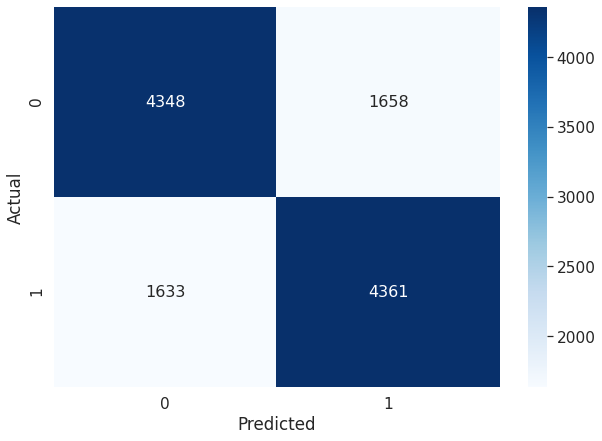

AUC: 0.7257518091


              precision    recall  f1-score   support

           0     0.7270    0.7239    0.7255      6006
           1     0.7245    0.7276    0.7260      5994

    accuracy                         0.7258     12000
   macro avg     0.7258    0.7258    0.7257     12000
weighted avg     0.7258    0.7258    0.7257     12000



In [29]:
## logistic regression
logitbase_output = model_fit_prediction(LogisticRegression(solver='liblinear'),train_x, train_y, test_x, test_y, kfold=kfold)

In [0]:
# save
#pickle.dump(logitbase_output, open('./logitbase_output.pkl', "wb"))
# load
#logitbase_output = pickle.load(open('./logitbase_output.pkl', "rb"))

### svm

Liblinear failed to converge, increase the number of iterations.


Accuracy on training set: 0.8091


Liblinear failed to converge, increase the number of iterations.


CV Accuracy on training set: 0.6855
Accuracy on test set: 0.7043


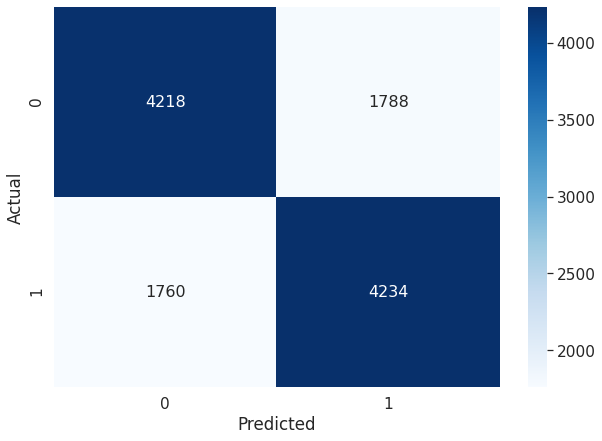

AUC: 0.7043353710
'LinearSVC' object has no attribute 'predict_proba'
              precision    recall  f1-score   support

           0     0.7056    0.7023    0.7039      6006
           1     0.7031    0.7064    0.7047      5994

    accuracy                         0.7043     12000
   macro avg     0.7043    0.7043    0.7043     12000
weighted avg     0.7043    0.7043    0.7043     12000



In [31]:
svmbase_output = model_fit_prediction(LinearSVC(random_state=5153, tol=1e-5), train_x, train_y, test_x, test_y, kfold)

In [0]:
# save
#pickle.dump(svmbase_output, open('./svmbase_output.pkl', "wb"))
# load
#svmbase_output = pickle.load(open('./svmbase_output.pkl', "rb"))

### Xgboost

In [0]:
def modelfit(model,train_X, train_Y ,cv_folds, useTrainCV=True, early_stopping_rounds=50):
    '''
    find appropriate number of boosting rounds (n_estimators)
    '''
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(train_X, label=train_Y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], folds=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds, verbose_eval=100)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the model on the data
    model.fit(train_X, train_Y)
    
    #Predict training set:
    train_predictions = model.predict(train_X)   
    print("\nModel Parameters")
    print(model.get_xgb_params())
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(train_Y, train_predictions))    
    return model, cvresult                

In [0]:
# initial base xgboost
xgbbase = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=-1,
    scale_pos_weight=1,
    random_state=24)
xgbbase, xgbbase_cvresult = modelfit(xgbbase, train_x, train_y, kfold, early_stopping_rounds=200)

[0]	train-logloss:0.690268+8.33124e-05	test-logloss:0.690549+0.000126666
[100]	train-logloss:0.606583+0.000981388	test-logloss:0.62418+0.00197362
[200]	train-logloss:0.569391+0.000982336	test-logloss:0.598988+0.00252121
[300]	train-logloss:0.543445+0.00100834	test-logloss:0.583049+0.00278584
[400]	train-logloss:0.522749+0.0012064	test-logloss:0.571283+0.00258816
[500]	train-logloss:0.505867+0.00100568	test-logloss:0.562692+0.00250507
[600]	train-logloss:0.491233+0.000909283	test-logloss:0.556096+0.00233763
[700]	train-logloss:0.478289+0.00100795	test-logloss:0.550782+0.0021761
[800]	train-logloss:0.466696+0.000881961	test-logloss:0.546369+0.00206755
[900]	train-logloss:0.456136+0.000938822	test-logloss:0.542321+0.00138531
[1000]	train-logloss:0.446276+0.000986114	test-logloss:0.539132+0.00120298
[1100]	train-logloss:0.437322+0.000975785	test-logloss:0.536896+0.000993933
[1200]	train-logloss:0.428991+0.00083041	test-logloss:0.534639+0.00109111
[1300]	train-logloss:0.421088+0.000678248	t

In [0]:
# save
pickle.dump(xgbbase, open('./xgbbase.pkl', "wb"))
# load
#xgbbase = pickle.load(open('./xgbbase.pkl', "rb"))

Accuracy on training set: 0.8799
CV Accuracy on training set: 0.7386
Accuracy on test set: 0.7473


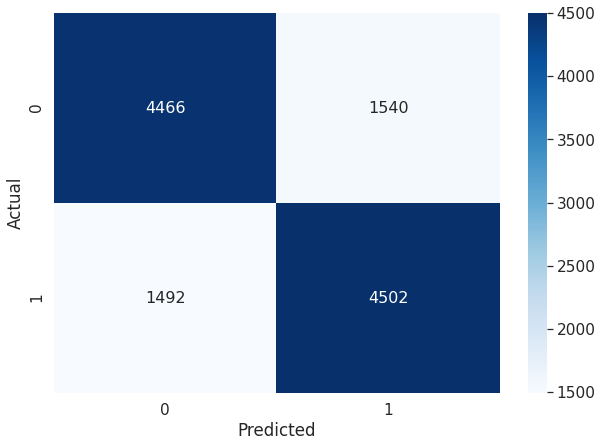

AUC: 0.7473370807


              precision    recall  f1-score   support

           0     0.7496    0.7436    0.7466      6006
           1     0.7451    0.7511    0.7481      5994

    accuracy                         0.7473     12000
   macro avg     0.7473    0.7473    0.7473     12000
weighted avg     0.7474    0.7473    0.7473     12000



In [0]:
xgbbase_output = model_fit_prediction(xgbbase, train_x, train_y, test_x, test_y, kfold, is_trained=True)

#### Tuning Xgboost

In [0]:
# max_depth, min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgbbase, param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=kfold)
gsearch1.fit(train_x, train_y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.7386458333333332)

In [0]:
# gamma
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=2730, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', n_jobs=-1, scale_pos_weight=1, seed=24), 
                        param_grid = param_test2, scoring='accuracy',n_jobs=-1, cv=kfold)
gsearch2.fit(train_x, train_y)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.2}, 0.7399375)

In [0]:
# refit a xgb model
xgbbase2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100000,
    max_depth=5,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=-1,
    scale_pos_weight=1,
    randome_state=24)
xgbbase2, xgbbase2_cvresult= modelfit(xgbbase2, train_x, train_y, kfold, early_stopping_rounds=200)

[0]	train-logloss:0.68994+6.08158e-05	test-logloss:0.690172+0.000216495
[100]	train-logloss:0.606086+0.000789672	test-logloss:0.62364+0.00208622
[200]	train-logloss:0.569207+0.0007862	test-logloss:0.598498+0.00227657
[300]	train-logloss:0.543246+0.000855708	test-logloss:0.582728+0.0024641
[400]	train-logloss:0.522838+0.00068934	test-logloss:0.571313+0.00238627
[500]	train-logloss:0.505795+0.000678483	test-logloss:0.562618+0.00211548
[600]	train-logloss:0.491277+0.000745091	test-logloss:0.555854+0.00196656
[700]	train-logloss:0.478449+0.000691091	test-logloss:0.550306+0.00200856
[800]	train-logloss:0.467053+0.000653869	test-logloss:0.545833+0.00202466
[900]	train-logloss:0.456343+0.000663711	test-logloss:0.542081+0.00151824
[1000]	train-logloss:0.446736+0.000497836	test-logloss:0.538975+0.00142498
[1100]	train-logloss:0.437783+0.00052974	test-logloss:0.536255+0.0012108
[1200]	train-logloss:0.429357+0.000572015	test-logloss:0.534126+0.00119486
[1300]	train-logloss:0.4214+0.00071891	test-

In [0]:
# subsample, colsample_bytree
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = xgbbase2, 
                        param_grid = param_test3, scoring='accuracy',n_jobs=-1, cv=kfold)

gsearch3.fit(train_x, train_y)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.7400208333333332)

In [0]:
# reg_alpha
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=2568, max_depth=5,
                                                  min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.7,
                                                  objective= 'binary:logistic', n_jobs=-1, scale_pos_weight=1,seed=24),
                        param_grid = param_test4, scoring='accuracy',n_jobs=-1, cv=kfold)
gsearch4.fit(train_x, train_y)
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 0.01}, 0.7395416666666665)

In [0]:
xgbTune = XGBClassifier(
    learning_rate =0.01,
    n_estimators=100000,
    max_depth=5,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    objective= 'binary:logistic',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=24)
xgbTuned, xgbTuned_cvresult = modelfit(xgbTune, train_x, train_y, kfold, early_stopping_rounds=500)

[0]	train-logloss:0.692859+9.2e-06	test-logloss:0.692895+1.33116e-05
[100]	train-logloss:0.672944+0.000341363	test-logloss:0.675582+0.000695152
[200]	train-logloss:0.660858+0.00039933	test-logloss:0.665478+0.00100401
[300]	train-logloss:0.651149+0.000488426	test-logloss:0.657645+0.00116837
[400]	train-logloss:0.642886+0.000604989	test-logloss:0.651022+0.00128439
[500]	train-logloss:0.635605+0.000667265	test-logloss:0.645257+0.00139896
[600]	train-logloss:0.629086+0.0007255	test-logloss:0.640256+0.00147655
[700]	train-logloss:0.623121+0.000796664	test-logloss:0.635757+0.00158493
[800]	train-logloss:0.617585+0.000795232	test-logloss:0.631635+0.00174194
[900]	train-logloss:0.612505+0.000813394	test-logloss:0.627909+0.00183339
[1000]	train-logloss:0.60767+0.000825176	test-logloss:0.624348+0.00191467
[1100]	train-logloss:0.603177+0.000838126	test-logloss:0.621108+0.00202554
[1200]	train-logloss:0.598907+0.000833955	test-logloss:0.618026+0.00210159
[1300]	train-logloss:0.594856+0.000799004	t

Accuracy on training set: 0.8810
CV Accuracy on training set: 0.7403
Accuracy on test set: 0.7514


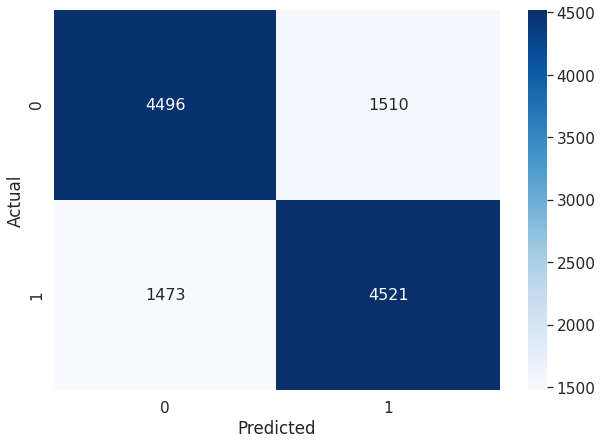

AUC: 0.7514195014


              precision    recall  f1-score   support

           0     0.7532    0.7486    0.7509      6006
           1     0.7496    0.7543    0.7519      5994

    accuracy                         0.7514     12000
   macro avg     0.7514    0.7514    0.7514     12000
weighted avg     0.7514    0.7514    0.7514     12000



In [0]:
xgbFinal_output = model_fit_prediction(xgbTuned, train_x, train_y, test_x, test_y, kfold, is_trained=True)

In [0]:
# save
pickle.dump(xgbTuned, open('./xgbTuned.pkl', "wb"))
# load
#xgbTuned = pickle.load(open('./xgbTuned.pkl', "rb"))

### Lightgbm
#### Bayesian Optimization

In [32]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
space ={'num_leaves': hp.choice('num_leaves', np.arange(10,70,5)), 
        'max_depth': hp.quniform("max_depth", 3, 11, 1),
        'min_child_samples': hp.choice('min_child_samples', np.arange(20, 200, 10)), 
        'min_child_weight': hp.choice('min_child_weight', np.arange(5, 30, 5)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': hp.choice('reg_alpha', [0, 1e-1, 1e-3, 1, 2, 5]),
        'reg_lambda': hp.choice('reg_lambda', [0, 1e-1, 1e-3, 1, 5, 10]),
        #'bagging_freq': 100,
        #'boosting': hp.choice('boosting', ['rf', 'gbdt']),
        'learning_rate': hp.choice('learning_rate', [0.1, 0.001, 0.005])
        }
# Classifier:
def hyperparameter_tuning(space):
    clf=LGBMClassifier(n_estimators=100000, num_leaves = space['num_leaves'], max_depth = int(space['max_depth']), reg_alpha = space['reg_alpha'], 
                       reg_lambda = space['reg_lambda'], min_child_samples = space['min_child_samples'], min_child_weight=space['min_child_weight'], 
                       subsample = space['subsample'], colsample_bytree = space['colsample_bytree'],
                       learning_rate=space['learning_rate'], n_jobs=-1)
    evaluation = [(train_x, train_y), (test_x, test_y)]
    
    clf.fit(train_x, train_y, eval_set=evaluation, eval_metric="logloss", early_stopping_rounds=200,verbose=False)
    pred = clf.predict(test_x)
    accuracy = accuracy_score(test_y, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK }
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

print (best)

SCORE:
0.705
SCORE:
0.7169166666666666
SCORE:
0.6931666666666667
SCORE:
0.7030833333333333
SCORE:
0.6951666666666667
SCORE:
0.6924166666666667
SCORE:
0.6971666666666667
SCORE:
0.7395
SCORE:
0.6845833333333333
SCORE:
0.6974166666666667
100%|██████████| 10/10 [32:22<00:00, 194.27s/it, best loss: -0.7395]
{'colsample_bytree': 0.8714554830347283, 'learning_rate': 0, 'max_depth': 4.0, 'min_child_samples': 2, 'min_child_weight': 0, 'num_leaves': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9285053849066283}


In [39]:
lgbTuned=LGBMClassifier(n_estimators=100000, num_leaves = 15, max_depth = 4, reg_alpha = 0, 
                   reg_lambda = 0.1, min_child_samples = 40, min_child_weight=5, 
                   subsample = 0.9285053849066283, colsample_bytree = 0.8714554830347283,
                   learning_rate=0.1, n_jobs=-1)
evaluation = [(train_x, train_y), (test_x, test_y)]
lgbTuned.fit(train_x, train_y, eval_set=evaluation, eval_metric="logloss", early_stopping_rounds=200,verbose=10000)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2823]	training's binary_logloss: 0.432431	valid_1's binary_logloss: 0.52995


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8714554830347283, importance_type='split',
               learning_rate=0.1, max_depth=4, min_child_samples=40,
               min_child_weight=5, min_split_gain=0.0, n_estimators=100000,
               n_jobs=-1, num_leaves=15, objective=None, random_state=None,
               reg_alpha=0, reg_lambda=0.1, silent=True,
               subsample=0.9285053849066283, subsample_for_bin=200000,
               subsample_freq=0)

Accuracy on training set: 0.8172
CV Accuracy on training set: 0.6933
Accuracy on test set: 0.7395


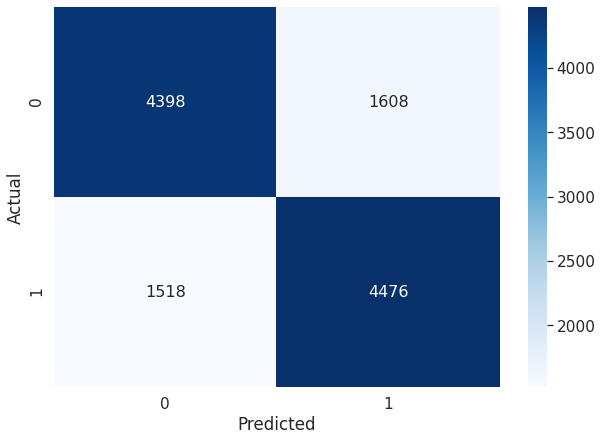

AUC: 0.7395072395


              precision    recall  f1-score   support

           0     0.7434    0.7323    0.7378      6006
           1     0.7357    0.7467    0.7412      5994

    accuracy                         0.7395     12000
   macro avg     0.7396    0.7395    0.7395     12000
weighted avg     0.7396    0.7395    0.7395     12000



In [42]:
lgb_output = model_fit_prediction(lgbTuned, train_x, train_y, test_x, test_y, kfold, is_trained=True)

In [0]:
xgbtuned = pickle.load(open('./xgbtuned.pkl', "rb"))

In [0]:
train_x_df = pd.DataFrame.sparse.from_spmatrix(train_x).sparse.to_dense()
featureNames = cv.get_feature_names() + feature_cols
train_x_df.columns = featureNames

In [0]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgbtuned)
shap_values = explainer.shap_values(train_x_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


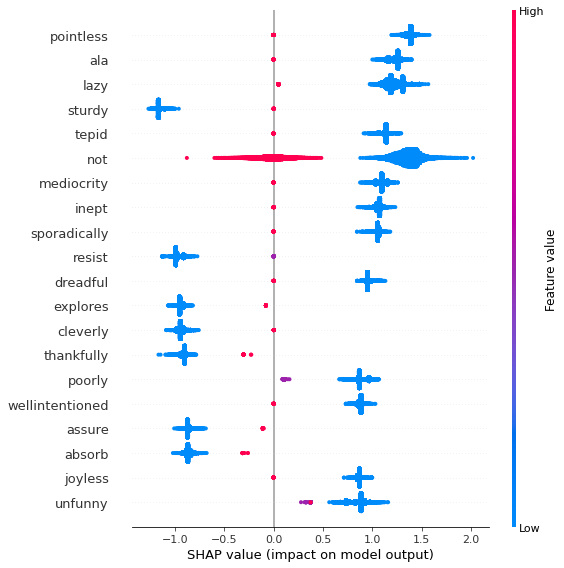

In [0]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_x_df)

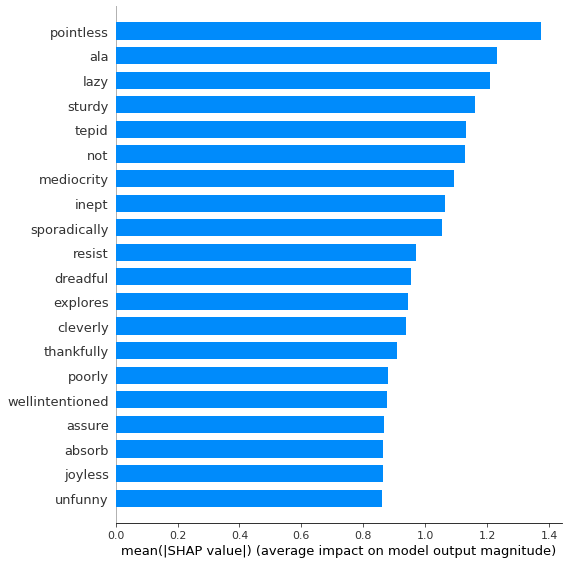

In [0]:
shap.summary_plot(shap_values, train_x_df, plot_type="bar")

In [0]:
# explore the impact of 'not' in reviews
# df_train['not_num'] = df_train.review_cleaned_lemma.apply(lambda x: len(re.findall('not', x)))

## Use Case I: 

In [0]:
# merge with moviw data to get the genre info
df_reviews_w_genre = df_reviews.merge(df_movies[['rotten_tomatoes_link', 'genre','in_theaters_date']])

In [0]:
df_reviews_w_genre = df_reviews_w_genre[(df_reviews_w_genre.in_theaters_date.dt.year<=2019) & (df_reviews_w_genre.in_theaters_date.dt.year>=2015)]
df_reviews_w_genre['genre'] = df_reviews_w_genre['genre'].astype(str)

In [47]:
df_reviews_w_genre.genre.value_counts()[:20]

Drama                                                   45663
Comedy                                                  17987
Documentary                                             10647
Drama, Mystery & Suspense                               10258
Action & Adventure, Drama, Science Fiction & Fantasy    10070
Comedy, Drama                                            9690
Action & Adventure, Drama                                9038
Horror                                                   7612
Action & Adventure, Science Fiction & Fantasy            7189
Art House & International, Drama                         6883
Mystery & Suspense                                       5104
Drama, Romance                                           4823
Action & Adventure, Drama, Mystery & Suspense            4731
Action & Adventure, Comedy                               4234
Action & Adventure                                       4155
Horror, Mystery & Suspense                               3395
Comedy, 

In [0]:
def fit_model_w_single_genre(df_reviews_w_genre, genre, N):
    # explain the model's predictions using SHAP
    df_reviews_w_single_genre = df_reviews_w_genre[df_reviews_w_genre['genre'].str.contains(genre)]
    if len(df_reviews_w_single_genre)>N:
        df_reviews_w_single_genre = df_reviews_w_single_genre.sample(n=N, random_state=24)
        df_reviews_w_single_genre.reset_index(drop=True, inplace=True)
    print('Number of rows: {}'.format(len(df_reviews_w_single_genre)))
    # train/test split
    df_train_w_single_genre = df_reviews_w_single_genre.sample(frac=0.8, random_state=5153) 
    df_test_w_single_genre = df_reviews_w_single_genre.drop(df_train_w_single_genre.index)
    print(df_train_w_single_genre.critic_icon.value_counts())
    print(df_test_w_single_genre.critic_icon.value_counts())
    ## build ml pipeline
    train_x_w_single_genre= union.fit_transform(df_train_w_single_genre)
    test_x_w_single_genre = union.transform(df_test_w_single_genre)
    train_y_w_single_genre = df_train_w_single_genre.label
    test_y_w_single_genre = df_test_w_single_genre.label
    # fit a xgboost model
    # initial base xgboost
    xgbbase_w_single_genre = XGBClassifier(
        learning_rate =0.1,
        n_estimators=100000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=-1,
        scale_pos_weight=1,
        random_state=24)
    xgbbase_w_single_genre, xgbbase_w_single_genre_cvresult = modelfit(xgbbase_w_single_genre, 
                                                                    train_x_w_single_genre, 
                                                                    train_y_w_single_genre, 
                                                                    kfold, 
                                                                    early_stopping_rounds=100)
    return xgbbase_w_single_genre, train_x_w_single_genre, cv
# explain the model's predictions using SHAP
def shap_evaluate_usecase_I(model, train_x, cv, genre, max_display=20):
    print('Sentiment Analysis on Movie Reviews in Genre: {}'.format(genre))
    train_x_df = pd.DataFrame.sparse.from_spmatrix(train_x).sparse.to_dense()
    featureNames = cv.get_feature_names() + feature_cols
    train_x_df.columns = featureNames
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_x_df)
    shap.summary_plot(shap_values, train_x_df, max_display=max_display)

Number of rows: 21540
Fresh     10748
Rotten     6484
Name: critic_icon, dtype: int64
Fresh     2664
Rotten    1644
Name: critic_icon, dtype: int64
[0]	train-logloss:0.683544+4.99976e-05	test-logloss:0.684047+0.000294623
[100]	train-logloss:0.545738+0.000464587	test-logloss:0.572099+0.0023816
[200]	train-logloss:0.498413+0.000853388	test-logloss:0.540589+0.00329981
[300]	train-logloss:0.4667+0.000460491	test-logloss:0.521607+0.00426499
[400]	train-logloss:0.442249+0.000517549	test-logloss:0.509431+0.00410525
[500]	train-logloss:0.42252+0.000712597	test-logloss:0.499455+0.00442627
[600]	train-logloss:0.40549+0.000740984	test-logloss:0.492134+0.00515788
[700]	train-logloss:0.390719+0.000737913	test-logloss:0.486395+0.00573583
[800]	train-logloss:0.37777+0.000641892	test-logloss:0.482246+0.00549925
[900]	train-logloss:0.366178+0.000647985	test-logloss:0.478888+0.0056792
[1000]	train-logloss:0.35554+0.000956839	test-logloss:0.476519+0.00587596
[1100]	train-logloss:0.345975+0.00118515	test-

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


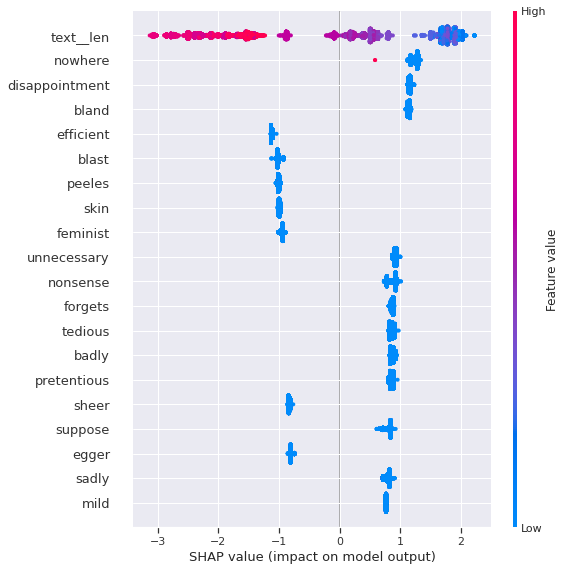

In [74]:
# Horror
genre = 'Horror'
xgbbase_w_single_genre, train_x_w_single_genre, cv = fit_model_w_single_genre(df_reviews_w_genre, genre, 30000)
shap_evaluate_usecase_I(xgbbase_w_single_genre, train_x_w_single_genre, cv, genre, 20)

Number of rows: 30000
Fresh     15702
Rotten     8298
Name: critic_icon, dtype: int64
Fresh     3917
Rotten    2083
Name: critic_icon, dtype: int64
[0]	train-logloss:0.680877+0.000182665	test-logloss:0.681258+0.000225698
[100]	train-logloss:0.548786+0.00163099	test-logloss:0.570525+0.00457097
[200]	train-logloss:0.509016+0.00179526	test-logloss:0.544751+0.00480961
[300]	train-logloss:0.4816+0.002035	test-logloss:0.528045+0.00534298
[400]	train-logloss:0.460164+0.00179134	test-logloss:0.516858+0.00582226
[500]	train-logloss:0.44238+0.00197495	test-logloss:0.508055+0.00662036
[600]	train-logloss:0.427096+0.00233491	test-logloss:0.500904+0.00691047
[700]	train-logloss:0.413954+0.00241559	test-logloss:0.49509+0.00769269
[800]	train-logloss:0.402201+0.00228345	test-logloss:0.48998+0.0082288
[900]	train-logloss:0.391568+0.00235718	test-logloss:0.486187+0.00878547
[1000]	train-logloss:0.38173+0.0024442	test-logloss:0.482634+0.00881593
[1100]	train-logloss:0.372678+0.00246113	test-logloss:0.47

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


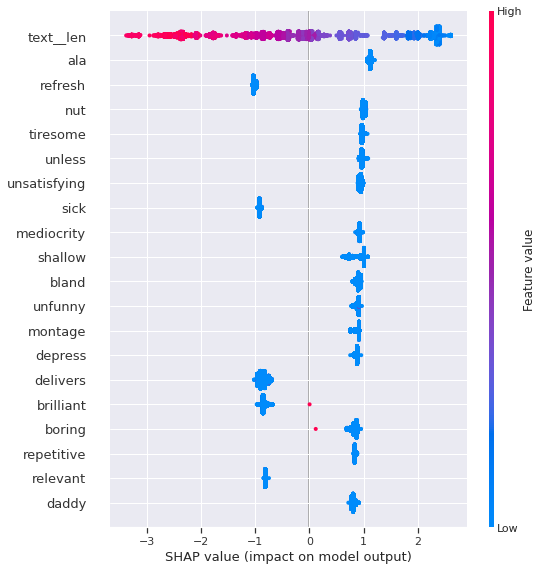

In [76]:
# Comedy
genre = 'Comedy'
xgbbase_w_single_genre, train_x_w_single_genre, cv = fit_model_w_single_genre(df_reviews_w_genre, genre, N=30000)
shap_evaluate_usecase_I(xgbbase_w_single_genre, train_x_w_single_genre, cv, genre)

Number of rows: 30000
Fresh     14752
Rotten     9248
Name: critic_icon, dtype: int64
Fresh     3645
Rotten    2355
Name: critic_icon, dtype: int64
[0]	train-logloss:0.684874+0.000117423	test-logloss:0.685232+0.000198584
[100]	train-logloss:0.565884+0.00125576	test-logloss:0.587167+0.00294556
[200]	train-logloss:0.524147+0.00161411	test-logloss:0.559089+0.0038391
[300]	train-logloss:0.495068+0.00150839	test-logloss:0.54192+0.00457714
[400]	train-logloss:0.472571+0.00168399	test-logloss:0.529504+0.00488797
[500]	train-logloss:0.454033+0.0015299	test-logloss:0.520457+0.00510449
[600]	train-logloss:0.438463+0.0015112	test-logloss:0.513101+0.00568913
[700]	train-logloss:0.424775+0.00173904	test-logloss:0.507633+0.0057839
[800]	train-logloss:0.412458+0.00183668	test-logloss:0.503224+0.00585078
[900]	train-logloss:0.401627+0.00175108	test-logloss:0.499278+0.00612364
[1000]	train-logloss:0.391767+0.00194266	test-logloss:0.496182+0.00650819
[1100]	train-logloss:0.382457+0.00172003	test-logloss

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


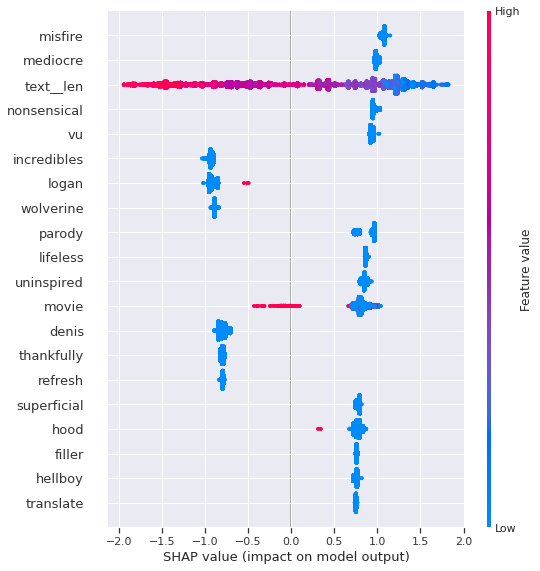

In [77]:
genre = 'Action & Adventure'
xgbbase_w_single_genre, train_x_w_single_genre, cv = fit_model_w_single_genre(df_reviews_w_genre, genre, 30000)
shap_evaluate_usecase_I(xgbbase_w_single_genre, train_x_w_single_genre, cv, genre)

### Neural Network

In [27]:
# init embedding
glove_embedding = WordEmbeddings('glove') #100
#flair_embedding_forward = FlairEmbeddings('news-forward') # 2048
#flair_embedding_backward = FlairEmbeddings('news-backward') # 2048
fastText_embedding = WordEmbeddings('en') #300
#bert_embedding = BertEmbeddings('bert-base-uncased') #3072

2020-04-24 08:42:14,713 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpxb4y5jp4


100%|██████████| 160000128/160000128 [00:11<00:00, 14139317.71B/s]

2020-04-24 08:42:26,698 copying /tmp/tmpxb4y5jp4 to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2020-04-24 08:42:26,888 removing temp file /tmp/tmpxb4y5jp4
2020-04-24 08:42:30,620 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmp9zy31e95


100%|██████████| 21494764/21494764 [00:02<00:00, 9388413.61B/s]

2020-04-24 08:42:33,578 copying /tmp/tmp9zy31e95 to cache at /root/.flair/embeddings/glove.gensim
2020-04-24 08:42:33,607 removing temp file /tmp/tmp9zy31e95



This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function


2020-04-24 08:42:36,229 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-news-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmptbnuysuc


100%|██████████| 1200000128/1200000128 [01:53<00:00, 10571002.71B/s]

2020-04-24 08:44:30,477 copying /tmp/tmptbnuysuc to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M.vectors.npy


2020-04-24 08:44:34,060 removing temp file /tmp/tmptbnuysuc
2020-04-24 08:44:34,789 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-news-300d-1M not found in cache, downloading to /tmp/tmpt8dmvu0b


100%|██████████| 54600983/54600983 [00:04<00:00, 12583397.12B/s]

2020-04-24 08:44:39,806 copying /tmp/tmpt8dmvu0b to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M


2020-04-24 08:44:39,873 removing temp file /tmp/tmpt8dmvu0b


In [0]:
nn_feature_cols = ['text__len', 'sent__num', 'url__cnt']

In [0]:
## create ndarrays for handcrafted features
nn_feature_pipe = make_pipeline(get_feature_ft, scaler)
train_x_nn_feature = nn_feature_pipe.fit(df_train).transform(df_train)
val_x_nn_feature = nn_feature_pipe.transform(df_test)
feature_no = train_x_nn_feature.shape[1]

In [0]:
def nn_trim(text):
    words = nltk.word_tokenize(text)
    return " ".join([i for i in words if len(i)<=15])

In [31]:
print('99% of the reviews have less than {} words'.format(np.percentile(np.array(df.words.apply(len)),99)))

99% of the reviews have less than 49.0 words


In [47]:
## tokenization and create word input tensor
## review_content or review_cleaned_lemma
words = df.review_content.str.lower().apply(expand_contractions).apply(remove_urls).apply(remove_stopwords).apply(nn_trim).apply(tokenize)
texts =words.tolist()
maxlen = 50  # We will cut answers after 50 words
max_words = 20000  # We will only consider the top 20,000 words in the dataset

EMBEDDING_DIM = 400
embedding = StackedEmbeddings([
                               glove_embedding,
                               fastText_embedding
                               ])
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
idx2wrd = {i:j for j, i in word_index.items()}
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating = 'post')

Found 53207 unique tokens.


In [48]:
labels = np.asarray(df.label)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (60000, 50)
Shape of label tensor: (60000,)


In [0]:
# train/val split, same as the previous split
train_x_nn_word = data[df_train.index]
train_y_nn = labels[df_train.index]
val_x_nn_word = data[df_test.index]
val_y_nn = labels[df_test.index]

In [0]:
# prepare word embeddings using pretrained word embedding 
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    token = Sentence(word)
    embedding.embed(token)
    for wrd in token:
        embedding_vector = wrd.embedding.cpu().detach().numpy()
        # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [51]:
sum([np.all(i==0) for i in embedding_matrix]) #if use review_cleaned_lemma - 12641

8503

In [0]:
# selected nn structure 
def create_model_nn():
    word_input = Input(shape=(maxlen,), dtype='int32',name='words_input')
    feature_input = Input(shape=(feature_no,), dtype='float32',name='features_input')
    words = Embedding(max_words, 100, input_length=maxlen)(word_input)
    output = Conv1D(64, 3, activation='relu', padding='same')(words)
    output = MaxPooling1D(2)(output)
    output= Dropout(0.5)(output)
    output = Conv1D(64, 3, activation='relu', padding='same')(output)
    output = Bidirectional(LSTM(30, dropout=0.2, recurrent_dropout=0.5))(output)
    output = concatenate([output, feature_input])
    output = Dense(32, activation='relu')(output)
    output= Dropout(0.5)(output)
    output = Dense(16, activation='relu')(output)
    output = Dense(1, activation='sigmoid')(output)
    model_nn = Model(inputs=[word_input, feature_input], outputs=[output])
    opt = optimizers.RMSprop(lr=0.0001)
    model_nn.compile(
        loss='binary_crossentropy', 
        optimizer=opt, 
        metrics = ['accuracy'])
    return model_nn

In [0]:
# training
epochs = 100
batch_size = 32
# control overfitting and save best model
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/model_nn_base_review_content.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]
model_nn = create_model_nn()
model_nn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      2000000     words_input[0][0]                
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 50, 100)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 100)      60400       spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

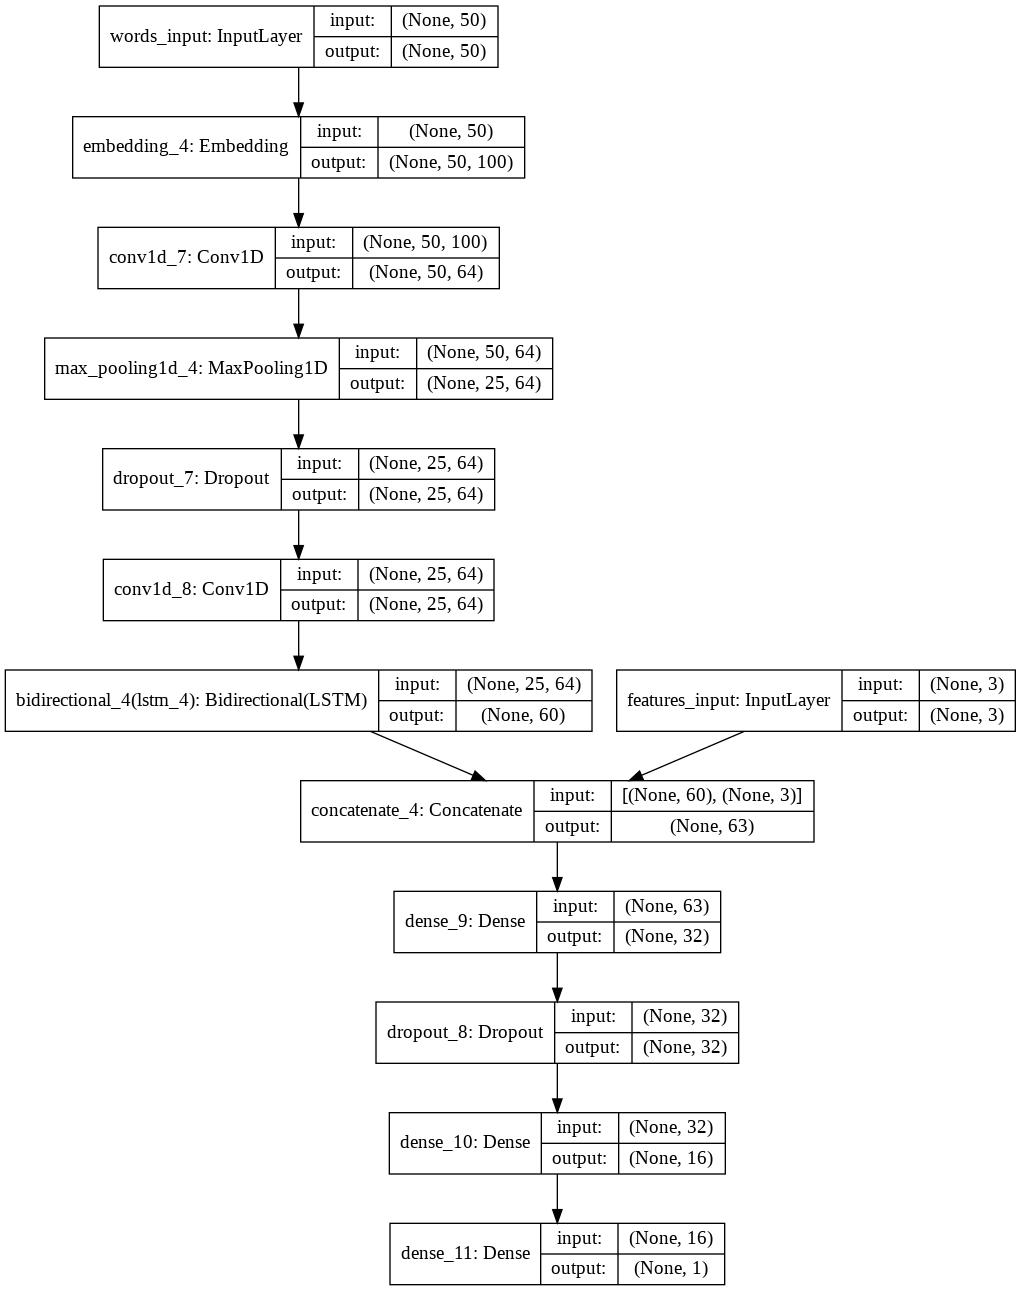

In [0]:
keras.utils.plot_model(model_nn, show_shapes=True, to_file='./plot/model_nn_base.png')

In [0]:
history = model_nn.fit([train_x_nn_word, train_x_nn_feature],train_y_nn, 
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks_list,
                        validation_data=([val_x_nn_word, val_x_nn_feature], val_y_nn)
                       )

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 166s 3ms/step - loss: 0.3295 - accuracy: 0.8584 - val_loss: 0.4751 - val_accuracy: 0.7789
Epoch 2/100
48000/48000 [==============================] - 166s 3ms/step - loss: 0.3303 - accuracy: 0.8586 - val_loss: 0.4742 - val_accuracy: 0.7795
Epoch 3/100
48000/48000 [==============================] - 160s 3ms/step - loss: 0.3301 - accuracy: 0.8585 - val_loss: 0.4755 - val_accuracy: 0.7793
Epoch 4/100
48000/48000 [==============================] - 161s 3ms/step - loss: 0.3287 - accuracy: 0.8588 - val_loss: 0.4764 - val_accuracy: 0.7789
Epoch 5/100
48000/48000 [==============================] - 161s 3ms/step - loss: 0.3274 - accuracy: 0.8601 - val_loss: 0.4767 - val_accuracy: 0.7788
Epoch 6/100
48000/48000 [==============================] - 161s 3ms/step - loss: 0.3264 - accuracy: 0.8602 - val_loss: 0.4769 - val_accuracy: 0.7783
Epoch 7/100
48000/48000 [==============================]

In [0]:
model_nn_base = load_model('model/model_nn_base_review_content.h5')

In [55]:
score,acc = model_nn_base.evaluate([train_x_nn_word, train_x_nn_feature], train_y_nn, batch_size = 32)
print('Training accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

48000/48000 [==============================] - 71s 1ms/step
Training accuracy:
score: 0.4263
acc: 0.8055


In [56]:
score,acc = model_nn_base.evaluate([val_x_nn_word, val_x_nn_feature], val_y_nn, batch_size = 32)
print('Test accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

12000/12000 [==============================] - 18s 1ms/step
Test accuracy:
score: 0.4870
acc: 0.7620


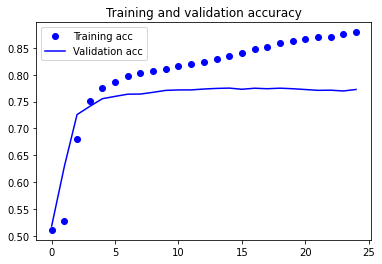

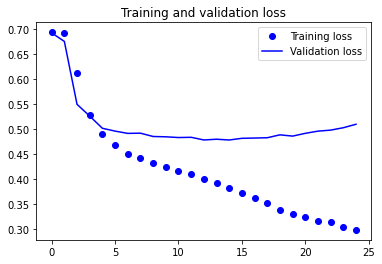

In [0]:
# plot the training/validation loss/acc
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# selected nn structure 
def create_model_nn():
    word_input = Input(shape=(maxlen,), dtype='int32',name='words_input')
    feature_input = Input(shape=(feature_no,), dtype='float32',name='features_input')
    words = Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False)(word_input)
    output = Conv1D(128, 3, activation='relu', padding='same')(words)
    output = MaxPooling1D(2)(output)
    output= Dropout(0.5)(output)
    output = Conv1D(128, 3, activation='relu', padding='same')(output)
    output = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.5))(output)
    output = concatenate([output, feature_input])
    output = Dense(32, activation='relu')(output)
    output= Dropout(0.5)(output)
    output = Dense(16, activation='relu')(output)
    output = Dense(1, activation='sigmoid')(output)
    model_nn = Model(inputs=[word_input, feature_input], outputs=[output])
    opt = optimizers.RMSprop(lr=0.00005)
    model_nn.compile(
        loss='binary_crossentropy', 
        optimizer=opt, 
        metrics = ['accuracy'])
    return model_nn

In [0]:
# training
epochs = 100
batch_size = 32
# control overfitting and save best model
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/model_nn_pretrained_review_content.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]
model_nn_pretrained = create_model_nn()
model_nn_pretrained.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 400)      21283200    words_input[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 50, 128)      153728      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 25, 128)      0           conv1d_3[0][0]                   
____________________________________________________________________________________________

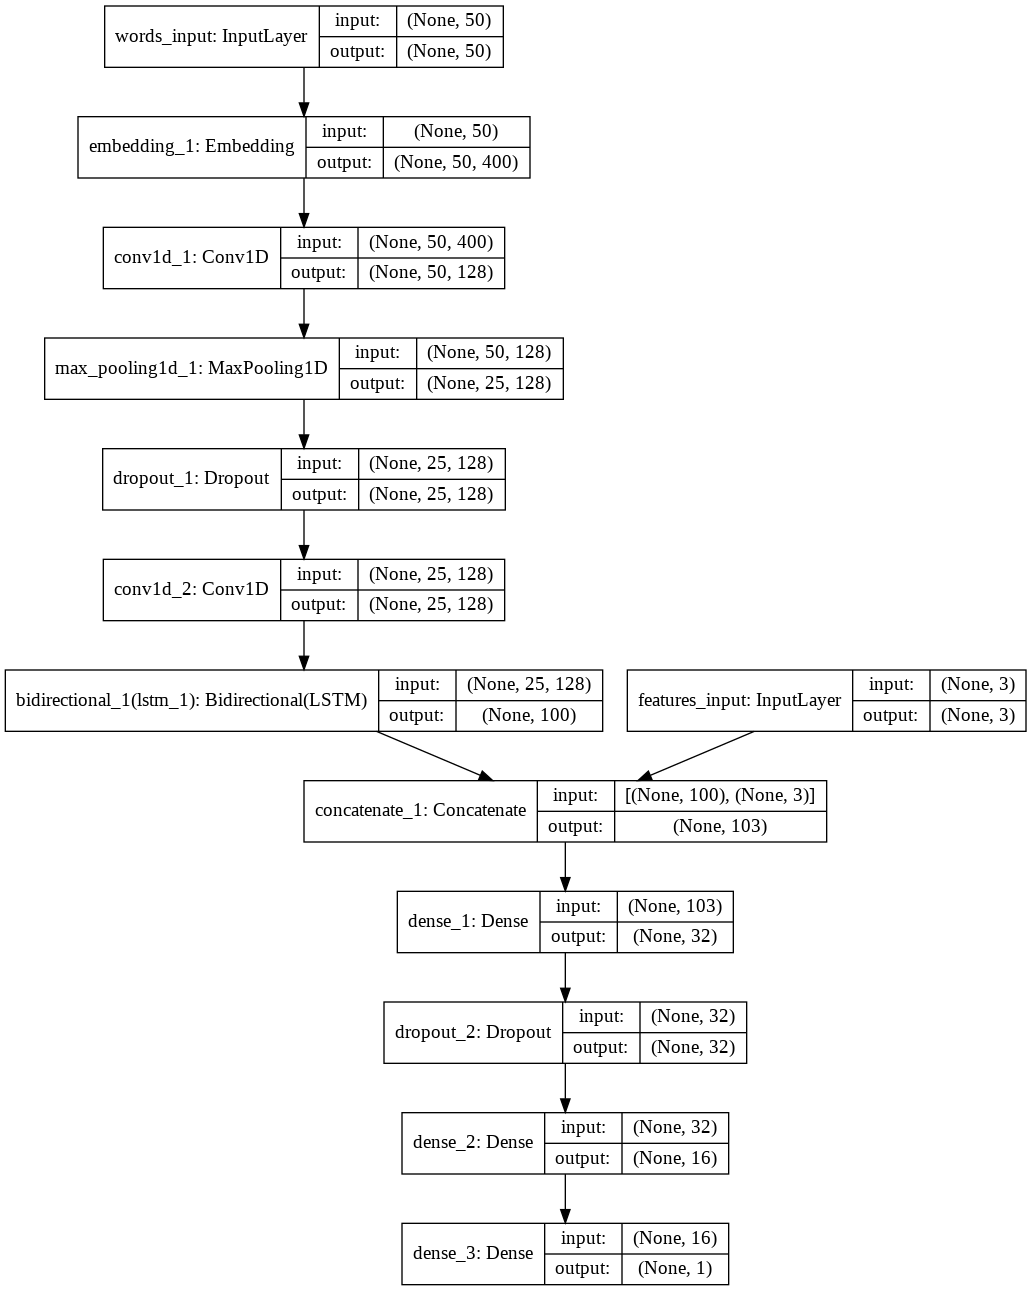

In [0]:
keras.utils.plot_model(model_nn_pretrained, show_shapes=True, to_file='./plot/model_nn_pretrained_review_content.png')

In [0]:
history = model_nn_pretrained.fit([train_x_nn_word, train_x_nn_feature],train_y_nn, 
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks_list,
                        validation_data=([val_x_nn_word, val_x_nn_feature], val_y_nn)
                       )

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 62s 1ms/step - loss: 0.6828 - accuracy: 0.5551 - val_loss: 0.6320 - val_accuracy: 0.6672
Epoch 2/100
48000/48000 [==============================] - 61s 1ms/step - loss: 0.6218 - accuracy: 0.6668 - val_loss: 0.5760 - val_accuracy: 0.7047
Epoch 3/100
48000/48000 [==============================] - 61s 1ms/step - loss: 0.5828 - accuracy: 0.7009 - val_loss: 0.5493 - val_accuracy: 0.7210
Epoch 4/100
48000/48000 [==============================] - 61s 1ms/step - loss: 0.5575 - accuracy: 0.7203 - val_loss: 0.5303 - val_accuracy: 0.7351
Epoch 5/100
48000/48000 [==============================] - 62s 1ms/step - loss: 0.5413 - accuracy: 0.7324 - val_loss: 0.5176 - val_accuracy: 0.7419
Epoch 6/100
48000/48000 [==============================] - 61s 1ms/step - loss: 0.5288 - accuracy: 0.7421 - val_loss: 0.5116 - val_accuracy: 0.7457
Epoch 7/100
48000/48000 [==============================] - 61s

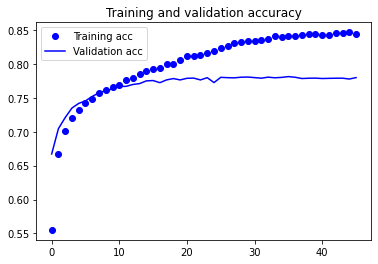

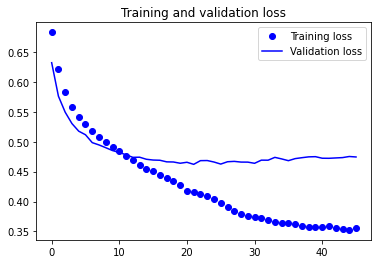

In [0]:
# plot the training/validation loss/acc
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model_nn_pretrained = load_model('model/model_nn_pretrained_review_content.h5')

In [45]:
score,acc = model_nn_pretrained.evaluate([train_x_nn_word, train_x_nn_feature], train_y_nn, batch_size = 32)
print('Training accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

48000/48000 [==============================] - 39s 819us/step
Training accuracy:
score: 0.3172
acc: 0.8807


In [46]:
score,acc = model_nn_pretrained.evaluate([val_x_nn_word, val_x_nn_feature], val_y_nn, batch_size = 32)
print('Test accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

12000/12000 [==============================] - 10s 813us/step
Test accuracy:
score: 0.4596
acc: 0.7813


## 1d cnn character embedding

In [0]:
def getChars(word_data):
    chars = np.zeros((word_data.shape[0], word_data.shape[1], maxCharLen))
    for i, sentence in enumerate(word_data):
        for j, token_idx in enumerate(sentence):
            if token_idx != 0:
                for k,char in enumerate(idx2wrd.get(token_idx)):
                    chars[i][j][k] = char2Idx.get(char, 0)
    return chars

In [0]:
standCharSets = set(" 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|")

In [0]:
maxCharLen = 15

In [0]:
char2Idx = {"_UNKNOWN_":0}
for c in ''.join(standCharSets):
    char2Idx[c] = len(char2Idx)
idx2Char = {i:j for j, i in char2Idx.items()}

In [0]:
chars = getChars(data)

In [0]:
train_x_nn_char = chars[df_train.index]
train_y_nn_char = chars[df_train.index]
val_x_nn_char = chars[df_test.index]
val_y_nn_char = chars[df_test.index]

In [0]:
word_input = Input(shape=(maxlen,), dtype='int32',name='words_input')
feature_input = Input(shape=(feature_no,), dtype='float32',name='features_input')
word_out = Embedding(max_words, 100, input_length=maxlen)(word_input)
# words = Embedding(len(word_index) + 1,
#                  EMBEDDING_DIM,
#                  weights=[embedding_matrix],
#                  input_length=maxlen,
#                  trainable=False)(word_input)

char_input = Input(shape=(maxlen,maxCharLen,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),10,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_input)
#dropout= Dropout(0.5)(embed_char_out)

# 1D Character CNN
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=10, padding='same',activation='relu', strides=1))(embed_char_out)
maxpool_out=TimeDistributed(MaxPooling1D(maxCharLen))(conv1d_out)
char_out = TimeDistributed(Flatten())(maxpool_out)
output = concatenate([word_out, char_out])
# output = MaxPooling1D(2)(output)
# output= Dropout(0.5)(output)
# output = Conv1D(64, 7, activation='relu')(output)
# output= Dropout(0.5)(output)
output = Bidirectional(LSTM(50, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))(output)
output = SpatialDropout1D(0.3)(output)
output = Conv1D(64, 3, padding='same', activation='relu')(output)
output = GlobalMaxPooling1D()(output)
output = concatenate([output, feature_input])
output = Dense(32, activation='relu')(output)
# output= Dropout(0.5)(output)
# output = Dense(30, activation='relu')(output)
# output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)
model_nn2 = Model(inputs=[word_input, char_input, feature_input], outputs=[output])
opt = optimizers.RMSprop(lr=0.0001)
model_nn2.compile(
    loss='binary_crossentropy', 
    optimizer=opt, 
    metrics = ['accuracy'])
model_nn2.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 50, 15)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 50, 15, 10)   940         char_input[0][0]                 
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 50, 15, 10)   310         char_embedding[0][0]             
__________________________________________________________________________________________________
words_input (In

In [0]:
# training
epochs = 100
batch_size = 32
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/model_nn_w_char.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]
history = model_nn2.fit([train_x_nn_word, train_x_nn_char, train_x_nn_feature],train_y_nn, 
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks_list,
                        validation_data=([val_x_nn_word, val_x_nn_char, val_x_nn_feature], val_y_nn)
                       )

In [6]:
model_nn_char = load_model('model/model_nn_w_char.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [67]:
score,acc = model_nn_char.evaluate([train_x_nn_word, train_x_nn_char, train_x_nn_feature], train_y_nn, batch_size = 32)
print('Training accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

48000/48000 [==============================] - 71s 1ms/step
Training accuracy:
score: 0.3730
acc: 0.8352


In [66]:
score,acc = model_nn_char.evaluate([val_x_nn_word, val_x_nn_char, val_x_nn_feature], val_y_nn, batch_size = 32)
print('Test accuracy:')
print("score: %.4f" % (score))
print("acc: %.4f" % (acc))

12000/12000 [==============================] - 18s 1ms/step
Test accuracy:
score: 0.4764
acc: 0.7765


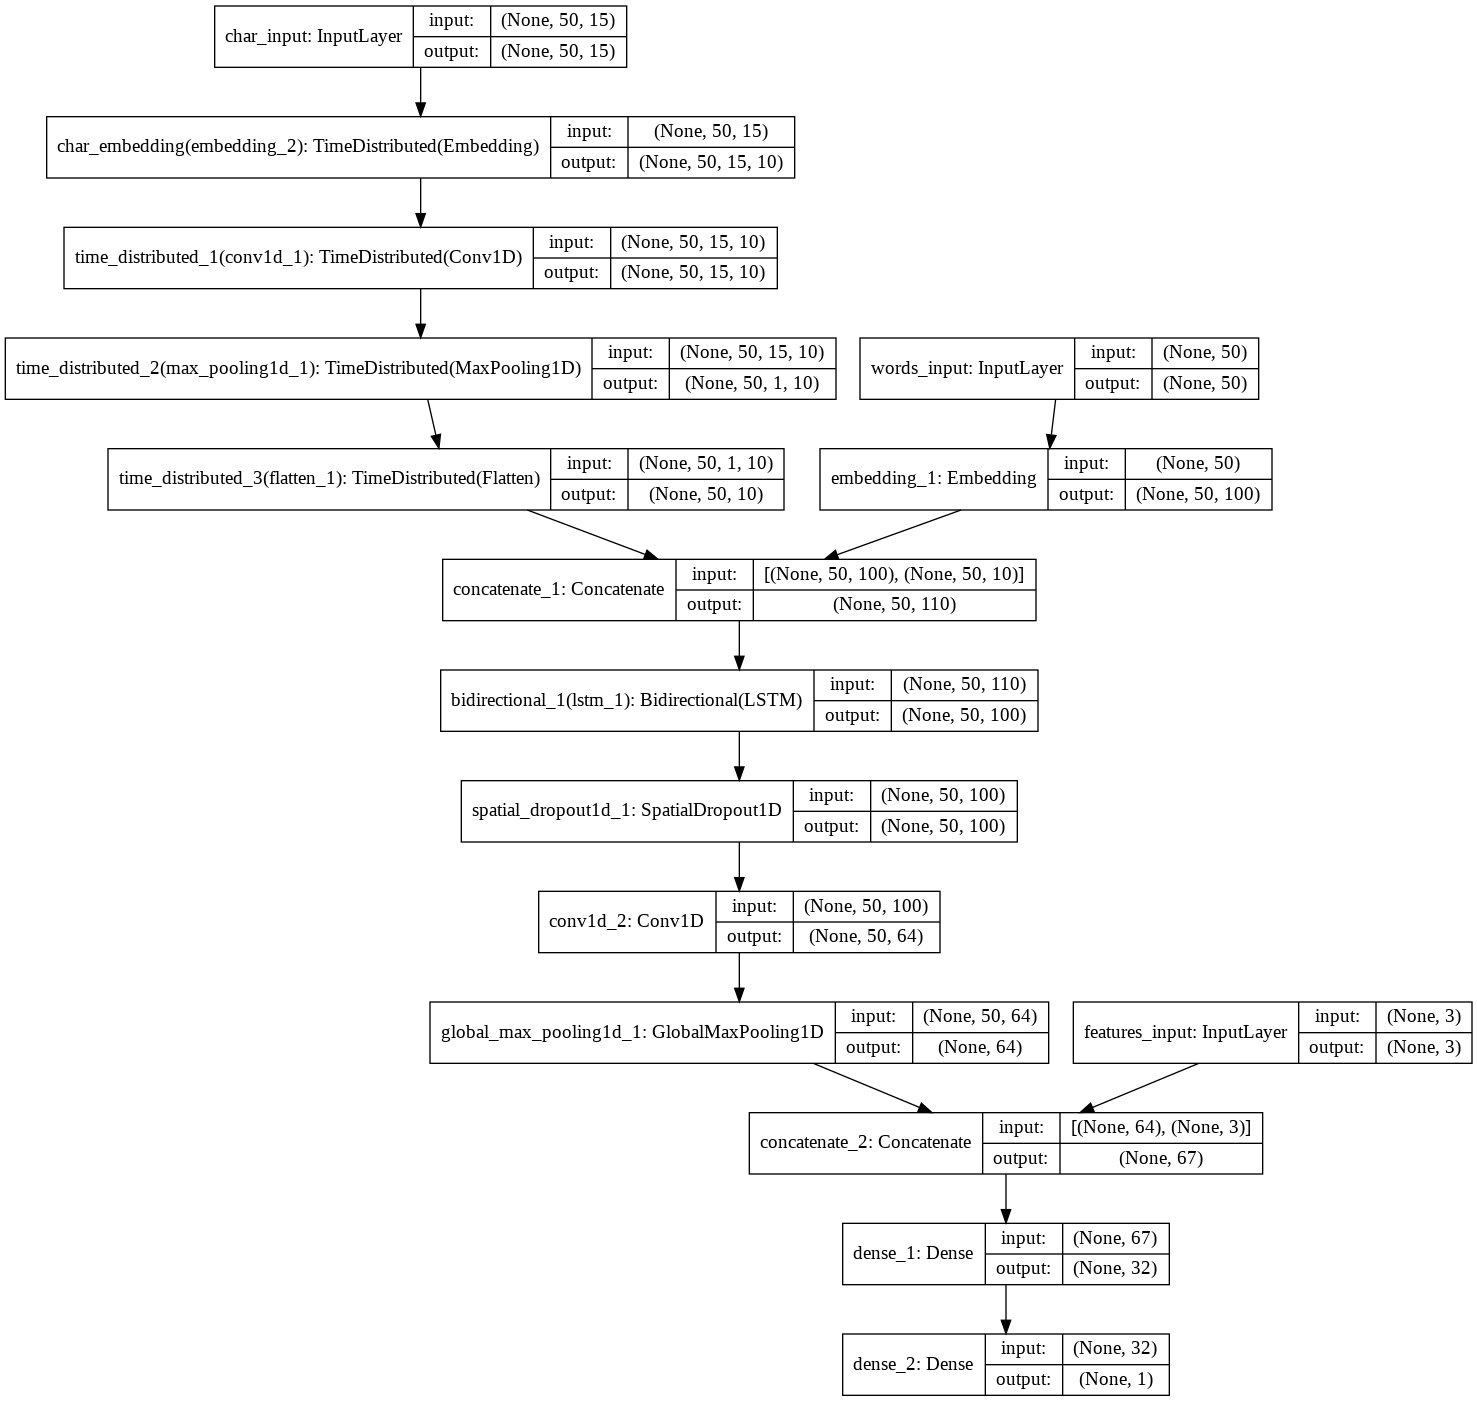

In [7]:
keras.utils.plot_model(model_nn_char, show_shapes=True, to_file='./plot/model_nn_char.png')